#### Feature Engineering & Encoding.

This notebooks is about pre-processing and feature engineering, we will create artifacts in order to deploy our model from the calculations made here. This will serve us to create also our pipelines.

**Regular Feature Engineering tasks:** 

- Geohashes. **DONE**

- Difference between area total y area construida. **DONE**
- Small differences between our mean district area's  **DONE**


**Spatial Feature Engineering tasks:**

- Point of interest features **DONE**
- Distance Bands **DONE**
- GeoClustering

**Encodings**

**Correlations**

In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
import geohash2 as gh #pip install geohash2
import gc

lima_data = pd.read_csv('../data/2020_Notebook01_clean_data.csv')
lima_data.describe()

#The coordinates were scraped without the -1
lima_data['latitud'] = lima_data['latitud']*-1
lima_data['longitud'] = lima_data['longitud']*-1

#### Feature Engineering

In [7]:
lima_data['areas_diff'] = lima_data['Area_total'] - lima_data['Area_constr']

In [8]:
lima_data['areas_proporcion'] = lima_data['Area_total']/lima_data['Area_constr']

In [9]:
drop_prop = lima_data[lima_data['areas_proporcion'] >= 4.0].index
lima_data.drop(drop_prop, inplace=True)

In [10]:
#This is as proxy to detect outliers, but it's not all the outlier processing 
tmp_table = lima_data.groupby('Barrio', as_index=False)['Area_total'].mean()
tmp_table = pd.merge(tmp_table, lima_data, on=['Barrio'], how='inner', suffixes=('_TMP','_ORIGIN'))
lima_data['diff_total_mean_district'] = tmp_table['Area_total_ORIGIN'] - tmp_table['Area_total_TMP']

In [11]:
lima_data.describe()

,latitud,longitud,Precio,Area_total,Area_constr,Precio_m2_total,Precio_m2_constr,Area_constr_cat,NroBanios,Dormitorios,Antiguedad,Cocheras,areas_diff,areas_proporcion,diff_total_mean_district
count,5231.000000,5231.000000,5.231000e+03,5231.000000,5231.000000,5231.000000,5231.000000,5231.000000,5231.000000,5231.000000,5231.000000,5231.000000,5231.000000,5231.000000,5076.000000
mean,-12.131348,-76.952278,2.652624e+06,474.113554,341.923724,6117.251223,7399.449532,9.663735,3.661250,4.410820,24.255783,2.672338,132.189830,1.352777,-0.262416
std,0.618621,0.445843,2.038581e+06,367.149884,165.449486,3518.636205,3876.101999,5.692226,0.967911,1.135062,9.977640,1.071479,279.731276,0.662417,318.714318
min,-53.163383,-79.221148,6.800000e+04,40.000000,31.000000,21.200000,23.555556,0.000000,1.000000,1.000000,1.000000,1.000000,-520.000000,0.171875,-629.233466
25%,-12.119827,-77.020543,1.225000e+06,238.000000,224.000000,3937.500000,5026.620224,5.000000,3.000000,4.000000,17.000000,2.000000,0.000000,1.000000,-181.273584
50%,-12.092327,-76.975682,2.158000e+06,340.000000,318.000000,5569.892473,6796.988270,10.000000,4.000000,4.000000,22.000000,2.000000,1.000000,1.003571,-56.428125
75%,-12.077283,-76.926842,3.430000e+06,595.000000,421.000000,7328.070476,8955.208128,14.000000,4.000000,5.000000,30.000000,3.000000,175.000000,1.581818,104.611538
max,-7.888933,-47.920490,1.225000e+07,2657.000000,1010.000000,55168.035000,81065.573770,19.000000,20.000000,20.000000,65.000000,6.000000,1937.000000,3.975000,2184.611538


#### GeoHashes

In [12]:
for num in range(5, 10):
    lima_data['geohash_grado{}'.format(num)] = lima_data.apply(lambda x: gh.encode(x['latitud'], x['longitud'], precision = num),axis=1)

In [13]:
top_geohashes = lima_data['geohash_grado7'].value_counts().iloc[0:7].keys().tolist()

#Which discrits have more housing offer?
lima_data[lima_data['geohash_grado7'].isin(top_geohashes)]['Barrio'].value_counts()

La Molina            242
Santiago de Surco     30
San Isidro            27
Miraflores             8
NoEspecifica           6
Barranco               1
Ate Vitarte            1
Lima Cercado           1
San Borja              1
La Victoria            1
Name: Barrio, dtype: int64

#### CAVEAT! Many posts doen't have exact coordinates but near reference points, that's why we will see same locations across different houses. We found 77 repeated coordinates but with different houses. In La Molina we take as reference EL Molicentro as well as Surco and San Isidro have their own point of reference


In [14]:
lima_data[lima_data['geohash_grado7'] == top_geohashes[0]][['latitud','longitud']].value_counts()

latitud     longitud  
-12.082020  -76.928234    77
            -76.928234     2
-12.081858  -76.928393     2
            -76.928393     2
-12.082040  -76.928287     1
-12.081852  -76.928062     1
-12.081714  -76.927820     1
-12.081075  -76.928427     1
dtype: int64

In [15]:
print(lima_data[lima_data['geohash_grado7'] == top_geohashes[1]][['latitud','longitud']].value_counts())
print(lima_data[lima_data['geohash_grado7'] == top_geohashes[2]][['latitud','longitud']].value_counts())

latitud     longitud  
-12.096333  -77.028072    84
dtype: int64
latitud     longitud  
-12.081242  -76.899002    29
            -76.899002     3
-12.081352  -76.899297     1
-12.081232  -76.898994     1
-12.081205  -76.899319     1
dtype: int64


In [16]:
lima_data.filter(regex='^(geohash*)').describe()    

,geohash_grado5,geohash_grado6,geohash_grado7,geohash_grado8,geohash_grado9
count,5231,5231,5231,5231,5231
unique,118,729,2711,3665,3786
top,6mc5p,6mc732,6mc732w,6mc5pjvv,6mc5pjvvg
freq,728,136,87,84,84


## Spatial Feature Engineering

In [19]:
import geopandas 
import osmnx as ox

from shapely.geometry import Point
import warnings
warnings.filterwarnings('ignore')

#We built an extra feature that is not included in notebook2 output. If i have Price per total square meter.
#To build Price per constructed meter I'll have to pivot values.
lima_data['Precio_m2_constr'] = (lima_data['Precio_m2_total'] * lima_data['Area_total'])/lima_data['Area_constr']

#We restricted data only for Lima and Callao.
filter_1 = (lima_data['Ciudad'].isin(['Lima','Callao','Cañete']))
filter_2 = (lima_data['latitud']!= 0)

lima_data.where(filter_1 & filter_2 , inplace=True)

#Import the Lima Shape File per districts.

peru_districts = geopandas.read_file('../data/GeoShape_Distritos/DISTRITOS.shp')
lima_districts = peru_districts[peru_districts['DEPARTAMEN'] == 'LIMA']

#Aggregate Polygons geometries to get Lima Department Polygon:
lima_department = geopandas.GeoSeries([lima_districts[lima_districts['DEPARTAMEN']=='LIMA'].unary_union])

#Aggregate Polygons geometries to get Lima District Polygon:
lima_province = geopandas.GeoSeries([lima_districts[lima_districts['PROVINCIA']=='LIMA'].unary_union])

#We only awant districts inside Lima.
lima_filter = (peru_districts['DEPARTAMEN'] == 'LIMA') 

lima_districts = peru_districts[lima_filter]

#We need shapely object. We can transform lats and longs into a shapely.Point object

gdf_lima = geopandas.GeoDataFrame(
    lima_data, geometry=geopandas.points_from_xy(lima_data.longitud, lima_data.latitud))

gdf_lima = gdf_lima[gdf_lima['geometry'].apply(lambda x: x.within(lima_districts.values[0]))]  #Validator.

#Temporal drop: Since there are many outliers we'll drop some values.
# -------------------------------------------------------------------
gdf_lima = gdf_lima[gdf_lima['Precio_m2_total'] < 9000]

gdf_lima = gdf_lima[gdf_lima['Precio_m2_constr']<11000]

In [24]:
#Re-setting index
gdf_lima = gdf_lima.reset_index(drop=True).reset_index().rename(columns={'index':'ID'})
#Checkin the Coordinate reference system
gdf_lima = gdf_lima.set_crs('epsg:4326')
gdf_lima.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

### Map Matching.

We will extract point of interests from OSMnx and transpolate those features to our housing dataset. First we will restrict our total area of interest and then we will unify that dataframe with our origins. We are choosing these categories: 'school','restaurant','parking','marketplace','bank','college','university','bus_station','police','clinic'

In [31]:
gdf_ch = gdf_lima.unary_union.convex_hull #Lima's Geometry

#amenities = ox.geometries_from_polygon(gdf_ch, tags={"amenity":['school','restaurant','parking','marketplace','bank','college','university','bus_station','police','clinic']})[["amenity","name","geometry"]]
#Inside Lima Filter
#amenities = amenities[amenities['geometry'].apply(lambda x: x.within(lima_province.values[0]))]
#amenities.to_csv('amenities.csv')

#Load our Amenities Dataset
from shapely import wkt
amenities = pd.read_csv('../data/to_load/amenities.csv')
geometry = amenities['geometry'].map(wkt.loads)
amenities.drop('geometry', axis=1, inplace=True)
amenities = geopandas.GeoDataFrame(amenities, crs='epsg:4326', geometry = geometry)

<AxesSubplot:>

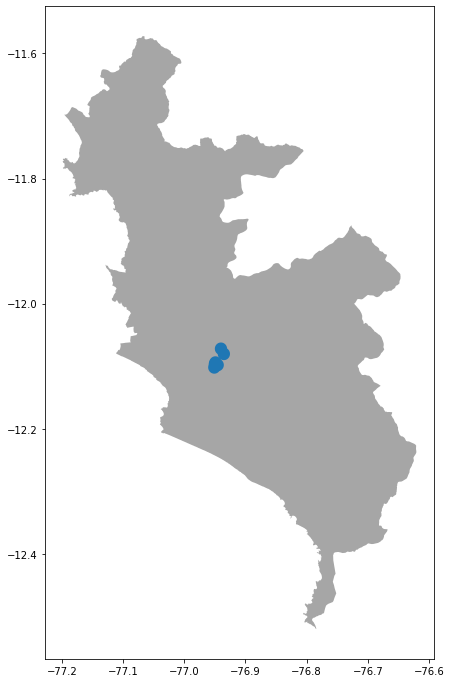

In [32]:
#Creating Buffer.
#--------------------------------------BUFFER HYPERPARAM--------------------------------------------
BUFFER_SIZE = 0.01
gdf_lima['buffer_500m'] = gdf_lima.buffer(BUFFER_SIZE)

#see one buffer to be sure makes sense.
buffer = gdf_lima.iloc[0:6,:]['buffer_500m']
fig, ax = plt.subplots(1, figsize=(12,12))
lima_province.plot(ax=ax,color='grey', alpha=0.70)
buffer.plot(ax=ax)

#### Creating All Point Of interest Features:

**CAVEAT:** 0.005 is an Hyperparameter that needs to be validated.

In [33]:
### CREATING POINT OF INTEREST FEATURES
dict_poi = {}
gdf_lima['buffer_500m'] = gdf_lima.buffer(0.005)
for amenity in amenities['amenity'].unique():
    amenity_df = amenities[amenities['amenity'] == amenity]
    joined = geopandas.sjoin(amenity_df, gdf_lima.set_geometry('buffer_500m')[['ID','buffer_500m']], op='within')
    poi_count = joined.reset_index().groupby("ID")["osmid"].count().to_frame('{}_poi_count'.format(amenity))
    dict_poi[amenity] = poi_count

In [35]:
#Merge with Origin Data (GDF)
#GDF size = 3477,25 - dict-bank 2776,1
for amenity_name, poi_count in dict_poi.items():
    
    temp_df = dict_poi[amenity_name].reset_index()
    gdf_lima = gdf_lima.merge(temp_df, on=['ID'],how='left').fillna(0.0)

#### Distance Bands and Distance Buffers:

We will use Distance Bands weight objects, considering other houses as "neighbors" if they are within the distance threshold. In other words, we will be considering the median of some feature around the spatial distance that we will define. For now we will just make Dormitorios and Area_total based feature

In [37]:
import libpysal.weights as weights

#THRESHOLD HYPERPARAMETER

THRESHOLD_HYPERPARAM = 500

d500_w = weights.DistanceBand.from_dataframe(gdf_lima, threshold=THRESHOLD_HYPERPARAM , silence_warnings=True)
d500_w.transform = 'r'

local_average_bedrooms = weights.lag_spatial(d500_w, gdf_lima[['Dormitorios']].values)

gdf_lima['local_average_bedrooms'] = local_average_bedrooms


area_500_w = weights.DistanceBand.from_dataframe(gdf_lima, threshold=500, silence_warnings=True)
area_500_w.transform = 'r'

local_average_total_area = weights.lag_spatial(area_500_w, gdf_lima[['Area_total']].values)

In [38]:
gdf_lima['local_average_total_area'] = local_average_total_area

### Dropping Geometry columns: 


In [44]:
gdf_lima.drop(['ID','geometry','buffer_500m'],axis=1,inplace=True)
lima_data = pd.DataFrame(gdf_lima)
lima_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4052 entries, 0 to 4051
Data columns (total 36 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   latitud                   4052 non-null   float64
 1   longitud                  4052 non-null   float64
 2   Barrio                    4052 non-null   object 
 3   Ciudad                    4052 non-null   object 
 4   Precio                    4052 non-null   float64
 5   Area_total                4052 non-null   float64
 6   Area_constr               4052 non-null   float64
 7   MONEDA                    4052 non-null   object 
 8   Precio_m2_total           4052 non-null   float64
 9   Precio_m2_constr          4052 non-null   float64
 10  Precio_cat                4052 non-null   object 
 11  Area_constr_cat           4052 non-null   float64
 12  NroBanios                 4052 non-null   float64
 13  Dormitorios               4052 non-null   float64
 14  Antigued

#### Correlations

<AxesSubplot:>

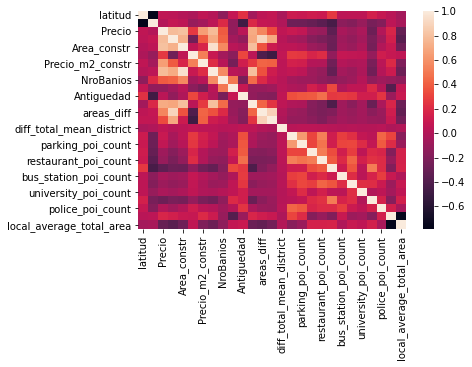

In [45]:
import seaborn as sns
import matplotlib.pyplot as plt

corr = lima_data.corr()
sns.heatmap(corr)

##### Target Selection

We have 4 ways to define our target data.

- Precio: Total price of the house

- Precio_m2_total: Price / total square meters 

- Precio_m2_constr: Price / constructed square meters

- Precio_cat: Categories prices

In [46]:
X = lima_data.drop(lima_data.filter(regex='(P?p?recio)').columns,axis=1)
Y = lima_data.filter(regex='(P?p?recio)')
print('columnas Y: {}'.format(Y.columns.values))

columnas Y: ['Precio' 'Precio_m2_total' 'Precio_m2_constr' 'Precio_cat']


In [47]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y['Precio_m2_total'], test_size=0.1, random_state = 215)

In [49]:
pd.concat([X_train,y_train],axis=1).to_csv('../data/2020_Notebook02_train_output.csv',index=False)

pd.concat([X_test,y_test],axis=1).to_csv('../data/2020_Notebook02_test_output.csv',index=False)